# Notebook for plotting the visualizations

In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle
import os
import sys
root = os.path.realpath(os.path.join(os.getcwd(),os.pardir))
sys.path.append(root)

from src.common import *
from src.model import main

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
sns.set(font="Arial")


In [91]:
train_data_file = os.path.join(DATA_DIR, "Data_Train.xlsx")
train_data = pd.read_excel(train_data_file)
train_data['Destination'].value_counts()

# Merge Dehli and New Delhi
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)

# Make day and month columns as Datetime columns.
if "Date_of_Journey" in train_data.columns:
    train_data['Journey_day'] = pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day
    train_data['Journey_month'] = pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.month
    train_data["Day_of_Week"]= pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day_of_week
    train_data["Day_of_Year"]= pd.to_datetime(
        train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day_of_year
    
    train_data.drop('Date_of_Journey', inplace=True, axis=1)

In [92]:
if "Dep_Time" in train_data.columns:
    train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
    train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
    train_data.drop('Dep_Time',axis=1,inplace=True)

if "Arrival_Time" in train_data.columns:
    train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
    train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
    train_data.drop('Arrival_Time',axis=1,inplace=True)

In [93]:
# Get information on duration
if "Duration" in train_data.columns:
    duration = list(train_data['Duration'])
    for i in range(len(duration)):
        if len(duration[i].split()) != 2:
            if 'h' in duration[i]:
                duration[i] = duration[i] + ' 0m'
            else:
                duration[i] = '0h ' + duration[i]

    duration_hour = []
    duration_min = []

    for i in duration:
        h,m = i.split()
        duration_hour.append(int(h[:-1]))
        duration_min.append(int(m[:-1]))

    train_data['Duration_hours'] = duration_hour
    train_data['Duration_mins'] = duration_min
    train_data.drop('Duration',axis=1,inplace=True)

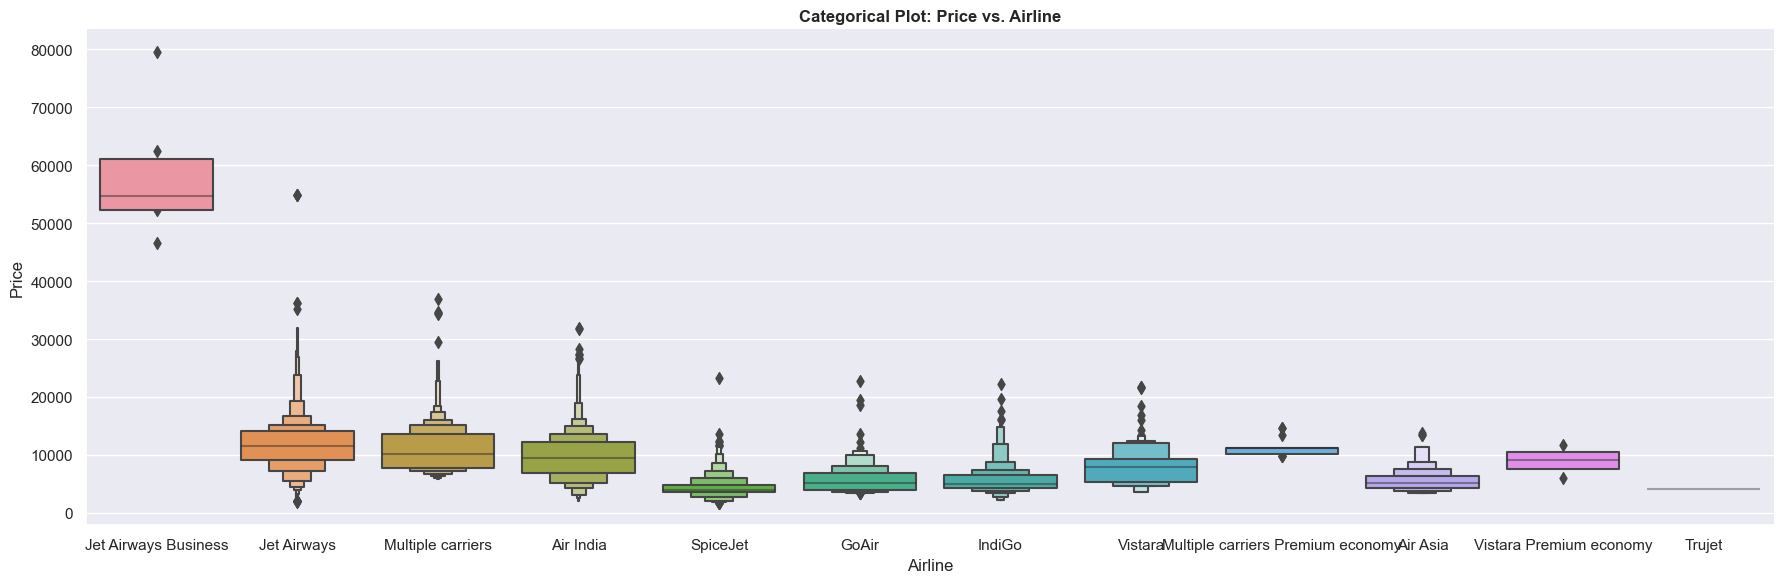

In [94]:
#Plot price information by price
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)
plt.xlabel("Airline")
plt.ylabel("Price")
plt.title("Categorical Plot: Price vs. Airline", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIG_RESULTS_DIR, "CatPriceAirline.png"), dpi=600)

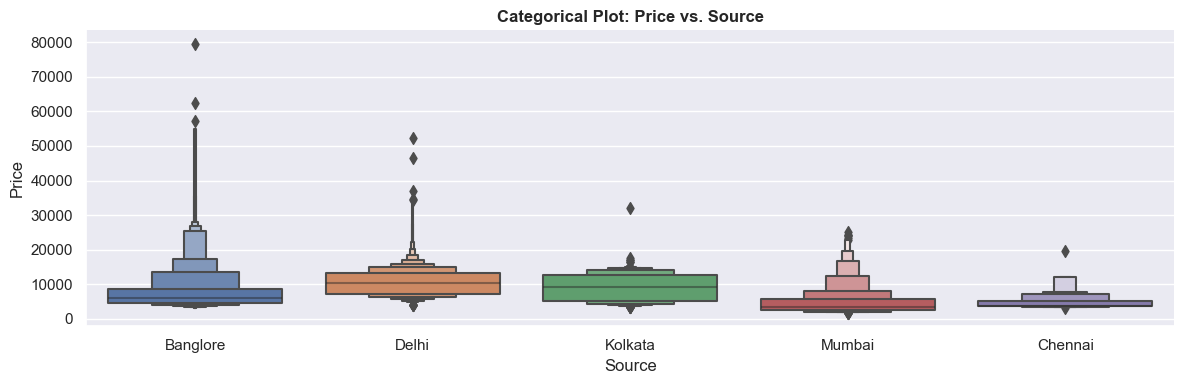

In [95]:
# Create dummy columns out of the Airline column.
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

# Plotting Source vs Price.
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)
plt.xlabel("Source")
plt.ylabel("Price")
plt.title("Categorical Plot: Price vs. Source", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIG_RESULTS_DIR, "CatPriceSource.png"), dpi=600)

In [96]:
destination = train_data[['Destination']]

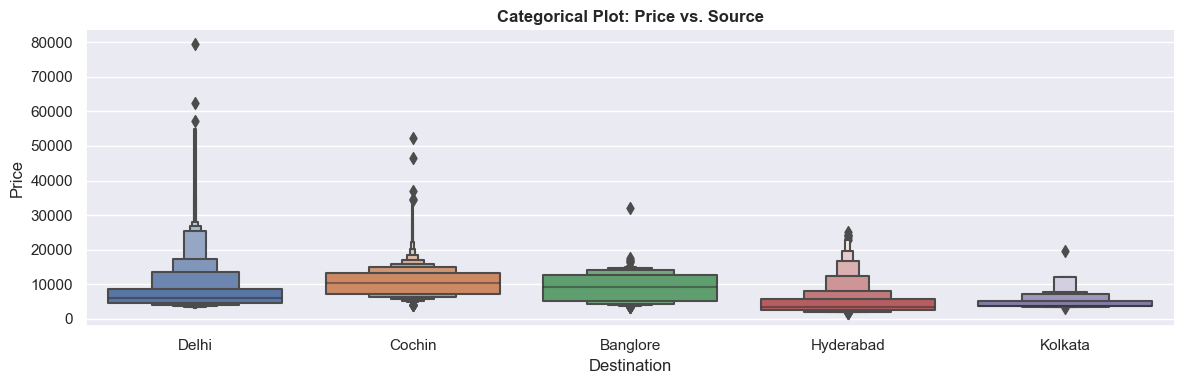

In [97]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
# Plotting Destination vs Price.
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)
plt.xlabel("Destination")
plt.ylabel("Price")
plt.title("Categorical Plot: Price vs. Source", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIG_RESULTS_DIR, "CatPriceDestination.png"), dpi=600)

In [98]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)


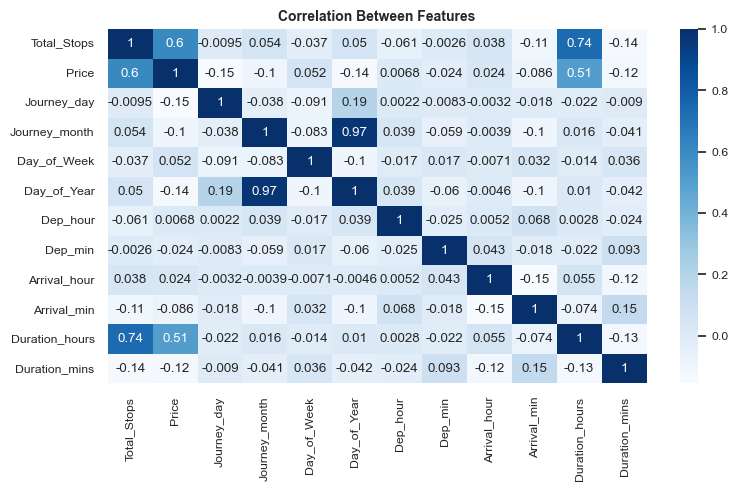

In [99]:

if "Route" in train_data.columns and "Additional_Info" in train_data.columns:
    train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)

data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.dropna(inplace=True)
try:
    data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
except:
    pass
# Taking out train data.
X = data_train.drop('Price',axis=1)
y = data_train['Price']
try:
    train_data.drop(['Airline','Source','Destination'],axis=1,inplace=True)
except:
    pass


sns.set(font_scale=.8)
fig,ax= plt.subplots(figsize=(8,5))
sns.heatmap(train_data.corr(),cmap='Blues',annot=True, ax=ax)
ax.set_title("Correlation Between Features", fontweight="bold", fontsize=10)
fig.tight_layout()
plt.tight_layout()
fig.savefig(os.path.join(FIG_RESULTS_DIR, "FeaturesHeatmap.png"), dpi=600)


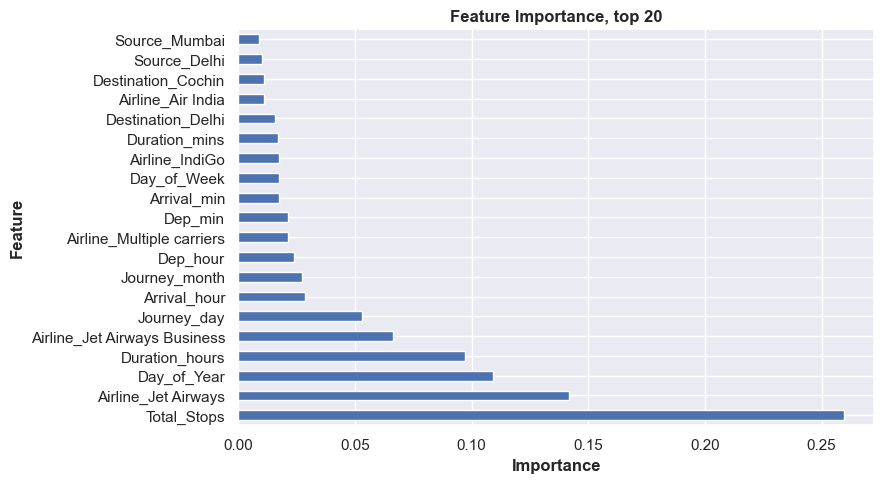

In [100]:
reg = ExtraTreesRegressor()
reg.fit(X,y)


sns.set(font_scale=1)

plt.figure(figsize = (9,5))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importance, top 20", fontweight="bold", fontsize=12)
plt.xlabel("Importance", fontweight="bold")
plt.ylabel("Feature", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIG_RESULTS_DIR, "FeaturesImportance.png"), dpi=600)


In [102]:
# Here we are using RandomizedSearchCV which just randomly tries out combinations and sees which one is the best out of them.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=0, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

model_file_name = os.path.join(MODEL_RESSULTS_DIR, 'flight_rf.pkl')

if not os.path.isfile(model_file_name):
    file = open(model_file_name, 'wb')
    pickle.dump(rf_random, file)


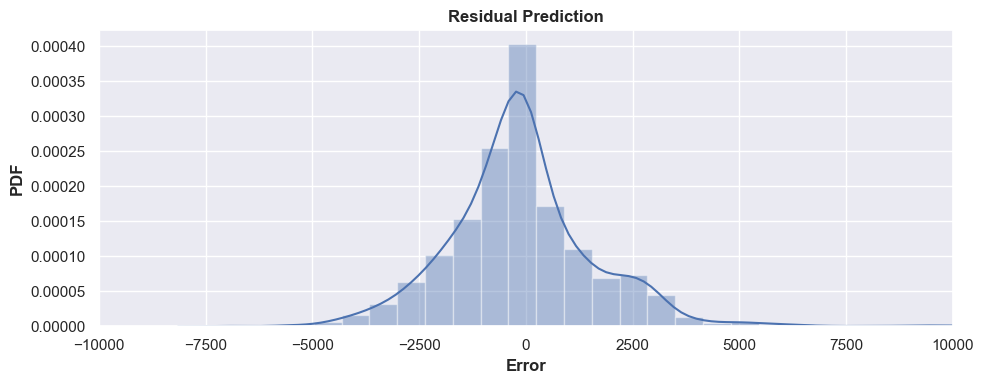

In [103]:
# Flight Price Prediction
prediction = rf_random.predict(X_test)
plt.figure(figsize = (10,4))
sns.distplot(y_test-prediction)
plt.title("Residual Prediction", fontweight="bold", fontsize=12)
plt.xlabel("Error", fontweight="bold")
plt.ylabel("PDF", fontweight="bold")
plt.xlim(-10000,10000)
plt.tight_layout()
plt.savefig(os.path.join(FIG_RESULTS_DIR, "ErrorPDF.png"), dpi=600)

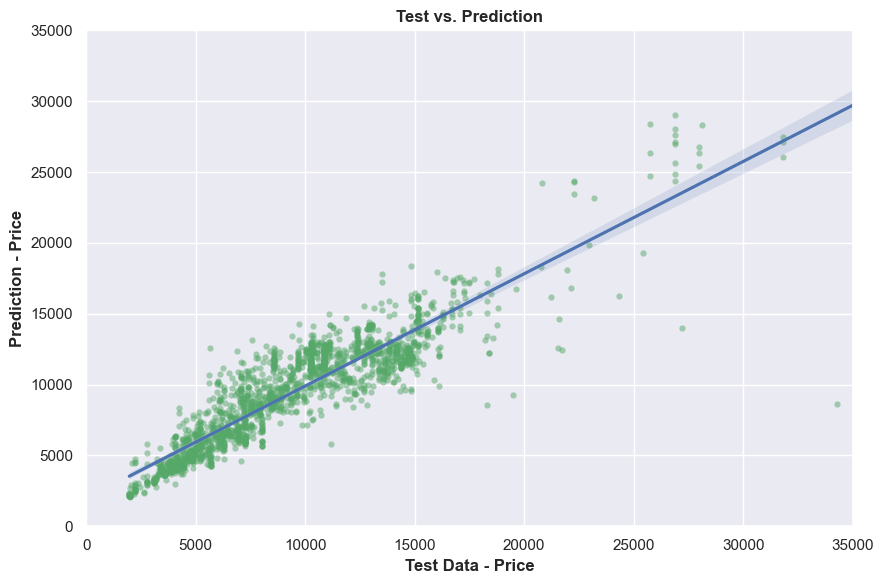

In [104]:
#fig,ax= plt.subplots(figsize = (8,4))
data = pd.DataFrame(columns=["Test", "Prediction"])
data["Test"]=y_test
data["Prediction"]=prediction


f, ax = plt.subplots(figsize=(9, 6))
#ax.set(xscale="log", yscale="log")
sns.regplot(data=data, x="Test", y="Prediction", ax=ax, 
            scatter_kws={"s": 20, "color":"g", "alpha": 0.5, "edgecolor": None,
                                                                     "linewidths": 0.})

plt.title("Test vs. Prediction", fontweight="bold", fontsize=12)
plt.xlabel("Test Data - Price", fontweight="bold")
plt.ylabel("Prediction - Price", fontweight="bold")
plt.xlim(0,35000)
plt.ylim(0,35000)
plt.tight_layout()
plt.savefig(os.path.join(FIG_RESULTS_DIR, "Test-v-Prediction.png"), dpi=600)

In [110]:
X.head()
for x in X.columns:
    print(x)

Total_Stops
Journey_day
Journey_month
Day_of_Week
Day_of_Year
Dep_hour
Dep_min
Arrival_hour
Arrival_min
Duration_hours
Duration_mins
Airline_Air India
Airline_GoAir
Airline_IndiGo
Airline_Jet Airways
Airline_Jet Airways Business
Airline_Multiple carriers
Airline_Multiple carriers Premium economy
Airline_SpiceJet
Airline_Trujet
Airline_Vistara
Airline_Vistara Premium economy
Source_Chennai
Source_Delhi
Source_Kolkata
Source_Mumbai
Destination_Cochin
Destination_Delhi
Destination_Hyderabad
Destination_Kolkata
